[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mUDx4uFpbS6jrD7lN-P7F7saefP_QJ31?usp=sharing)


In [ ]:
# Import required packages
!python -m spacy download fr_core_news_sm
#import fr_core_news_sm
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 

     |████████████████████████████████| 14.7 MB 29.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
# Import additional packages
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr.examples import sentences 
from spacy.lang.fr import French
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/training_data.csv"
df = pd.read_csv(path, index_col=0)
df.head()


,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    4800 non-null   object
 1   difficulty  4800 non-null   object
dtypes: object(2)
memory usage: 112.5+ KB


In [ ]:
# Base rate: the data-set is a bit balanced!
df.difficulty.value_counts()


A1    813
C2    807
C1    798
A2    795
B1    795
B2    792
Name: difficulty, dtype: int64

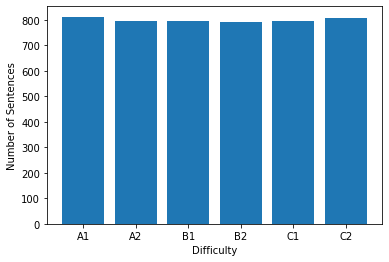

In [ ]:
difficulty_count = df.groupby("difficulty").count()
plt.bar(difficulty_count.index.values, difficulty_count["sentence"])
plt.xlabel("Difficulty")
plt.ylabel("Number of Sentences")
plt.show()

In [ ]:
round(df.difficulty.value_counts().max()/ len(df), 4)


0.1694

### tokening the date with spaCy


In [ ]:
# Create a list of punctuation marks
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create a list of stopwords
#stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

list(stop_words)[:10]

['moi-même',
 'lui-meme',
 'memes',
 'parler',
 'cinquantaine',
 'quinze',
 'différentes',
 'surtout',
 'je',
 'dring']

In [ ]:
# Load French language model
import fr_core_news_sm
#sp = spacy.load('en_core_web_sm')
sp = fr_core_news_sm.load()

# Create tokenizer function
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    ## alternative way
    # mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens

# Example
#New_sentence = df["sentence"].sample()
New_sentence = df["sentence"].head()
New_sentence.values[0]

"Les coûts kilométriques réels peuvent diverger sensiblement des valeurs moyennes en fonction du moyen de transport utilisé, du taux d'occupation ou du taux de remplissage, de l'infrastructure utilisée, de la topographie des lignes, du flux de trafic, etc."

In [ ]:
spacy_tokenizer(New_sentence.values[0])


['coût',
 'kilométrique',
 'réel',
 'pouvoir',
 'diverger',
 'sensiblemer',
 'valeur',
 'moyenner',
 'fonction',
 'moyen',
 'transport',
 'utiliser',
 'taux',
 'occupation',
 'taux',
 'remplissage',
 'infrastructure',
 'utiliser',
 'topographie',
 'ligne',
 'flux',
 'trafic',
 'etc.']

In [ ]:
#Vectorization Feature Engineering (TF-IDF)
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer) # we use the above defined tokenizer

## classification of level using logistic regression

In [ ]:
# Select features
X = df['sentence'] # the features we want to analyze
ylabels = df['difficulty'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234, stratify=ylabels)

X_train

id
962     Le réalisateur m'a d'abord demandé de me mettr...
1886    Après quelques mois de cette pauvreté noble, a...
2721    L'indicateur n'était que de 40% chez les femme...
1025    L'objectif de ce type de voyage est d'être act...
4048    Et, en France, beaucoup moins de filles que de...
                              ...                        
3693     Je vais prendre ma douche dans ma salle-de-bain.
3408    Après l'éruption de 1754, la plus grosse connu...
4289    Léonard est initié par Verrocchio aux nombreus...
3312    On en trouve des exemples dans l'ouvrage "L'in...
269     On peut aussi aller au théâtre, dans les musée...
Name: sentence, Length: 3840, dtype: object

In [ ]:
y_train


id
962     B1
1886    C1
2721    A2
1025    B1
4048    B2
        ..
3693    A1
3408    B1
4289    C2
3312    C2
269     A1
Name: difficulty, Length: 3840, dtype: object

In [ ]:
# Define classifier
classifier = LogisticRegression(multi_class="multinomial")

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fef141447a0>)),
                ('classifier', LogisticRegression(multi_class='multinomial'))])

In [ ]:
# Evaluate the model
def evaluate(test, pred):
  precision = precision_score(test, pred,average=None)
  recall = recall_score(test, pred, average=None)
  f1= f1_score(test, pred, average=None)
  print(f'CONFUSION MATRIX:\n{confusion_matrix(test, pred)}')
  print(f"ACCURACY SCORE:\n{accuracy_score(test, pred) :.4f}")
  print(f'CLASSIFICATION REPORT:')
  print("Precision:\t {0:4f}".format(precision_score(test, pred,average="macro"))) 
  print("Recall:\t {0:4f}".format(recall_score(test, pred, average="macro")))
  print("F1_Score:\t {0:4f}".format(f1_score(test, pred, average="macro")))


In [ ]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[77 24 24 21  7 10]
 [40 49 34 16 14  6]
 [25 25 46 30 13 20]
 [11  9 15 60 28 35]
 [ 6 10  4 32 78 30]
 [ 8  7 11 22 33 80]]
ACCURACY SCORE:
0.4062
CLASSIFICATION REPORT:
Precision:	 0.403978
Recall:	 0.405670
F1_Score:	 0.402873
